In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [615]:
data = pd.read_csv('data/kobe.csv')

In [616]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [617]:
# Выбираю фичи, которыми буду работать
df = data[data['shot_made_flag'].notnull()]
df = df.reset_index()[['shot_id', 'combined_shot_type', 'action_type', 'loc_x', 'loc_y', 'minutes_remaining', 'period', 'game_date', 'shot_type', 'shot_made_flag']]
print(df.shape[0])
df.head(10)

25697


,shot_id,combined_shot_type,action_type,loc_x,loc_y,minutes_remaining,period,game_date,shot_type,shot_made_flag
0,2,Jump Shot,Jump Shot,-157,0,10,1,2000-10-31,2PT Field Goal,0.0
1,3,Jump Shot,Jump Shot,-101,135,7,1,2000-10-31,2PT Field Goal,1.0
2,4,Jump Shot,Jump Shot,138,175,6,1,2000-10-31,2PT Field Goal,0.0
3,5,Dunk,Driving Dunk Shot,0,0,6,2,2000-10-31,2PT Field Goal,1.0
4,6,Jump Shot,Jump Shot,-145,-11,9,3,2000-10-31,2PT Field Goal,0.0
5,7,Layup,Layup Shot,0,0,8,3,2000-10-31,2PT Field Goal,1.0
6,9,Jump Shot,Jump Shot,-65,108,6,3,2000-10-31,2PT Field Goal,1.0
7,10,Jump Shot,Running Jump Shot,-33,125,3,3,2000-10-31,2PT Field Goal,0.0
8,11,Jump Shot,Jump Shot,-94,238,1,3,2000-10-31,3PT Field Goal,0.0
9,12,Jump Shot,Jump Shot,121,127,11,1,2000-11-01,2PT Field Goal,1.0


In [618]:
# Несколько функций для описания зон, из которых сделан бросок
# Перевод из декартовых координат в полярные
def cart2pol(x, y):
    rr = np.sqrt(x**2 + y**2)
    ra = np.degrees(np.arctan2(y, x))
    if ra < 0:
        ra = 360 + ra
    return rr, ra

# Перевод из полярных координат в декартовы
def pol2cart(r, a):
    x = r*np.cos(a/180*np.pi)
    y = r*np.sin(a/180*np.pi)
    return [x, y]

# Начертить дугу (в поляных координатах)
def drawArc(r, a1, a2):
    angls = range(a1, a2)
    x = [pol2cart(r, a)[0] for a in angls]
    y = [pol2cart(r, a)[1] for a in angls]
    plt.plot(x, y, color='red', alpha=0.7)

# Начертить луч (в поляных координатах)
def drawRay(a, r1, r2):
    rads = range(r1, r2)
    x = [pol2cart(r, a)[0] for r in rads]
    y = [pol2cart(r, a)[1] for r in rads]
    plt.plot(x, y, color='red', alpha=0.7)
    
# Зону броска по номеру
def drawZone(indx):
    if zones[indx]['r1'] > 0:
        drawArc(zones[indx]['r1'], zones[indx]['a1'], zones[indx]['a2'])
    drawArc(zones[indx]['r2'], zones[indx]['a1'], zones[indx]['a2'])        
    drawRay(zones[indx]['a1'], zones[indx]['r1'], zones[indx]['r2'])
    drawRay(zones[indx]['a2'], zones[indx]['r1'], zones[indx]['r2'])        
    
# Определить номер зоны по координатам
def encodeZone(x, y):
    r, a = cart2pol(x, y)
    for i in range(len(zones)):
        if ((zones[i]['a1'] <= a) and (a < zones[i]['a2'])) and ((zones[i]['r1'] <= r) and (r < zones[i]['r2'])):
            return zones[i]['zone']
    return 15


In [619]:
# one_hot преобразование для фичи
def get_one_hot(pdf, col, prfx):
    """
    @param df pandas DataFrame
    @param column to encode 
    @return a aDataFrame with one-hot encoding
    """
    dummies = pd.get_dummies(pdf[col], prefix=prfx, drop_first=False)
    pdf = pd.concat([pdf, dummies], axis=1)
        
    old_cols = pdf.columns
    new_cols = [old_col.replace(' ', '_') for old_col in old_cols]
    pdf.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    
    return pdf

In [620]:
# Описание зон (в полярных координатах)
zones = { 0: {'r1':0, 'r2':50, 'a1': 0, 'a2': 360, 'zone': 0},

          1: {'r1':50, 'r2':120, 'a1': 345, 'a2': 360, 'zone': 1},
          2: {'r1':50, 'r2':120, 'a1': 0, 'a2': 20, 'zone': 1},
          3: {'r1':50, 'r2':120, 'a1': 20, 'a2': 75, 'zone': 2},
          4: {'r1':50, 'r2':120, 'a1': 75, 'a2': 105, 'zone': 3},
          5: {'r1':50, 'r2':120, 'a1': 105, 'a2': 160, 'zone': 4},
          6: {'r1':50, 'r2':120, 'a1': 160, 'a2': 195, 'zone': 5},

          7: {'r1':120, 'r2':220, 'a1': 345, 'a2': 360, 'zone': 6},
          8: {'r1':120, 'r2':220, 'a1': 0, 'a2': 20, 'zone': 6},
          9: {'r1':120, 'r2':220, 'a1': 20, 'a2': 75, 'zone': 7},
         10: {'r1':120, 'r2':220, 'a1': 75, 'a2': 105, 'zone': 8},
         11: {'r1':120, 'r2':220, 'a1': 105, 'a2': 160, 'zone': 9},
         12: {'r1':120, 'r2':220, 'a1': 160, 'a2': 195, 'zone': 10},

         13: {'r1':220, 'r2':300, 'a1': 345, 'a2': 360, 'zone': 11},
         14: {'r1':220, 'r2':300, 'a1': 0, 'a2': 20, 'zone': 11},
         15: {'r1':220, 'r2':300, 'a1': 20, 'a2': 75, 'zone': 12},
         16: {'r1':220, 'r2':300, 'a1': 75, 'a2': 105, 'zone': 13},
         17: {'r1':220, 'r2':300, 'a1': 105, 'a2': 160, 'zone': 14},
         18: {'r1':220, 'r2':300, 'a1': 160, 'a2': 195, 'zone': 15},
        }
        # else 'zone': 15


In [621]:
# Разбиваю все броски по зонам
dfm0 = df.copy(deep=True)
dfm0['zone'] = 0
cnt = 0
for i in range(dfm0.shape[0]):
    x = dfm0.loc[i,'loc_x']
    y = dfm0.loc[i,'loc_y']
    cnt += 1
    try:
        dfm0.loc[i,'zone'] = encodeZone(x, y)
    except Exception:
        print('Err on: ', x, y)
print(cnt)
dfm0[['loc_x', 'loc_y', 'zone']].head()

25697


,loc_x,loc_y,zone
0,-157,0,10
1,-101,135,9
2,138,175,12
3,0,0,0
4,-145,-11,10


In [622]:
dfm0.shape[0]

25697

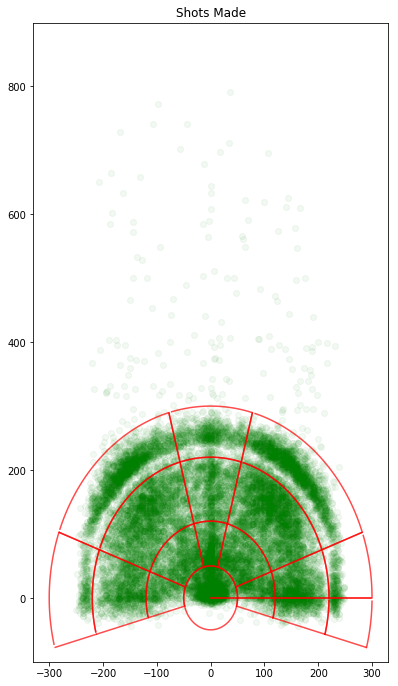

In [623]:

court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))

plt.subplot(121)
plt.scatter(dfm0.loc_x, dfm0.loc_y, color='green', alpha=alpha)
#for i in range(1, dfm0.shape[0]):
#    plt.text(x=dfm0.loc[i,'loc_x'], y=dfm0.loc[i,'loc_y'], s=dfm0.loc[i,'zone'], alpha=0.05)

plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-100, 900])

for i in range(len(zones)):
    drawZone(i)


In [624]:
dfm0.head()

,shot_id,combined_shot_type,action_type,loc_x,loc_y,minutes_remaining,period,game_date,shot_type,shot_made_flag,zone
0,2,Jump Shot,Jump Shot,-157,0,10,1,2000-10-31,2PT Field Goal,0.0,10
1,3,Jump Shot,Jump Shot,-101,135,7,1,2000-10-31,2PT Field Goal,1.0,9
2,4,Jump Shot,Jump Shot,138,175,6,1,2000-10-31,2PT Field Goal,0.0,12
3,5,Dunk,Driving Dunk Shot,0,0,6,2,2000-10-31,2PT Field Goal,1.0,0
4,6,Jump Shot,Jump Shot,-145,-11,9,3,2000-10-31,2PT Field Goal,0.0,10


In [625]:
dfm0 = dfm0.drop(['loc_x', 'loc_y'], axis=1)
dfm0.head()


,shot_id,combined_shot_type,action_type,minutes_remaining,period,game_date,shot_type,shot_made_flag,zone
0,2,Jump Shot,Jump Shot,10,1,2000-10-31,2PT Field Goal,0.0,10
1,3,Jump Shot,Jump Shot,7,1,2000-10-31,2PT Field Goal,1.0,9
2,4,Jump Shot,Jump Shot,6,1,2000-10-31,2PT Field Goal,0.0,12
3,5,Dunk,Driving Dunk Shot,6,2,2000-10-31,2PT Field Goal,1.0,0
4,6,Jump Shot,Jump Shot,9,3,2000-10-31,2PT Field Goal,0.0,10


Text(0.5,1,'')

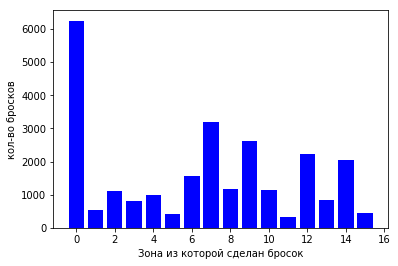

In [626]:
#Распределение бросков по зонам
groups = dfm0['zone'].value_counts()
plt.bar(groups.index, groups, color='b', linestyle='-')
plt.xlabel('Зона из которой сделан бросок')
plt.ylabel('кол-во бросков')
plt.title('')

In [627]:
onehot_zone = get_one_hot(dfm0[['zone']], 'zone', 'zone')
onehot_zone = onehot_zone.drop(['zone'], axis=1)
onehot_zone.head()

,zone_0,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Text(0.5,1,'')

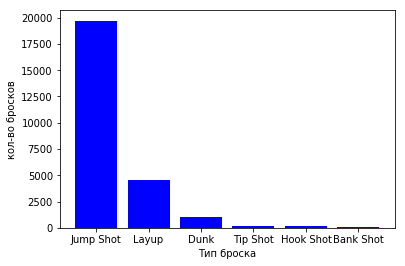

In [628]:
#Распределение бросков по типам
groups = df['combined_shot_type'].value_counts()
plt.bar(groups.index, groups, color='b', linestyle='-')
plt.xlabel('Тип броска')
plt.ylabel('кол-во бросков')
plt.title('')

In [629]:
onehot_cst = get_one_hot(df[['combined_shot_type']], 'combined_shot_type', 'cst')
onehot_cst = onehot_cst.drop(['combined_shot_type'], axis=1)
onehot_cst.head()
#df = pd.merge(df, one_hot_df, left_index = True, right_index = True)

,cst_Bank_Shot,cst_Dunk,cst_Hook_Shot,cst_Jump_Shot,cst_Layup,cst_Tip_Shot
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


Text(0,0.5,'кол-во бросков')

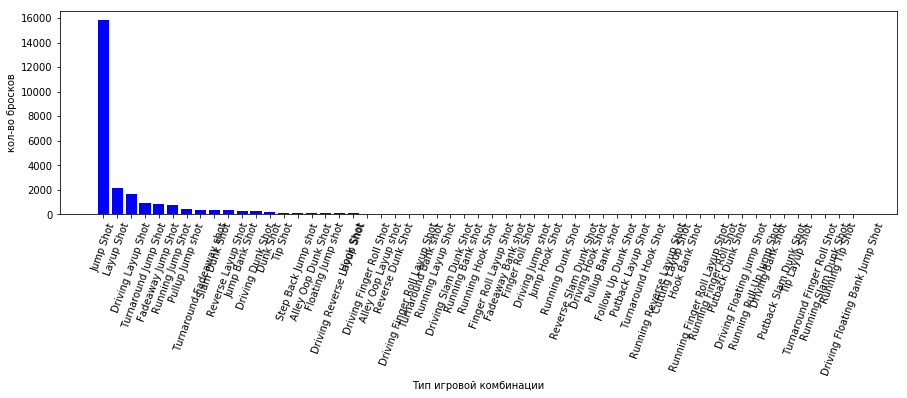

In [630]:
#Распределение бросков по типу игровой комбинации
plt.subplots(figsize=(15, 3.75))
groups = df['action_type'].value_counts()
plt.bar(groups.index, groups, color='b', linestyle='-')
plt.xticks(rotation=70)
plt.xlabel('Тип игровой комбинации')
plt.ylabel('кол-во бросков')


In [631]:
onehot_act = get_one_hot(df[['action_type']], 'action_type', 'act')
onehot_act = onehot_act.drop(['action_type'], axis=1)
onehot_act.head()

,act_Alley_Oop_Dunk_Shot,act_Alley_Oop_Layup_shot,act_Cutting_Layup_Shot,act_Driving_Bank_shot,act_Driving_Dunk_Shot,act_Driving_Finger_Roll_Layup_Shot,act_Driving_Finger_Roll_Shot,act_Driving_Floating_Bank_Jump_Shot,act_Driving_Floating_Jump_Shot,act_Driving_Hook_Shot,...,act_Running_Tip_Shot,act_Slam_Dunk_Shot,act_Step_Back_Jump_shot,act_Tip_Layup_Shot,act_Tip_Shot,act_Turnaround_Bank_shot,act_Turnaround_Fadeaway_shot,act_Turnaround_Finger_Roll_Shot,act_Turnaround_Hook_Shot,act_Turnaround_Jump_Shot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0,0.5,'кол-во бросков')

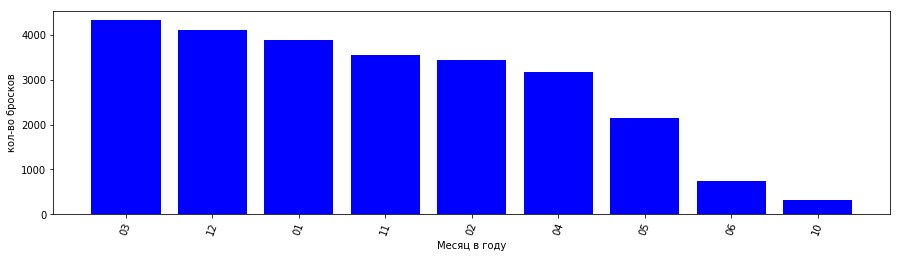

In [632]:
#Распределение бросков по месяцам года в котором были игры
plt.subplots(figsize=(15, 3.75))
groups = seasons['sseason'].value_counts()
plt.bar(groups.index, groups, color='b', linestyle='-')
plt.xticks(rotation=70)
plt.xlabel('Месяц в году')
plt.ylabel('кол-во бросков')


In [633]:
import datetime
seasons = df[['game_date']]
seasons['sseason'] = seasons['game_date'].apply(lambda x: x[5:7])
onehot_ssn = get_one_hot(seasons, 'sseason', 'ssn')
onehot_ssn = onehot_ssn.drop(['sseason', 'game_date'], axis=1)
onehot_ssn.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ssn_01,ssn_02,ssn_03,ssn_04,ssn_05,ssn_06,ssn_10,ssn_11,ssn_12
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0


Text(0.5,1,'')

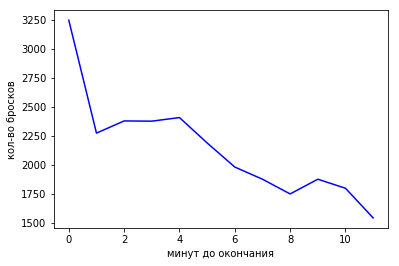

In [634]:
#Распределение бросков по количесву минут до конча периода
groups = df['minutes_remaining'].value_counts()
groups = groups.sort_index()
plt.plot(groups.index, groups, color='b', linestyle='-')
plt.xlabel('минут до окончания')
plt.ylabel('кол-во бросков')
plt.title('')

In [635]:
onehot_mnts = get_one_hot(df[['minutes_remaining']], 'minutes_remaining', 'mnts')
onehot_mnts = onehot_mnts.drop(['minutes_remaining'], axis=1)
onehot_mnts.head()


,mnts_0,mnts_1,mnts_2,mnts_3,mnts_4,mnts_5,mnts_6,mnts_7,mnts_8,mnts_9,mnts_10,mnts_11
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


In [636]:
#Далее строим модель, тренируем и тестируем...

In [637]:
groups = data['shot_made_flag'].value_counts()
groups.head()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

In [638]:
onehot_zone.head()

,zone_0,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [639]:
dfe = pd.merge(
    onehot_zone,
    onehot_cst,
    left_index = True,
    right_index = True
)
dfe = pd.merge(
    dfe,
    onehot_act,
    left_index = True,
    right_index = True
)
dfe = pd.merge(
    dfe,
    onehot_ssn,
    left_index = True,
    right_index = True
)
dfe = pd.merge(
    dfe,
    onehot_mnts,
    left_index = True,
    right_index = True
)



In [640]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 98 columns):
zone_0                                 25697 non-null uint8
zone_1                                 25697 non-null uint8
zone_2                                 25697 non-null uint8
zone_3                                 25697 non-null uint8
zone_4                                 25697 non-null uint8
zone_5                                 25697 non-null uint8
zone_6                                 25697 non-null uint8
zone_7                                 25697 non-null uint8
zone_8                                 25697 non-null uint8
zone_9                                 25697 non-null uint8
zone_10                                25697 non-null uint8
zone_11                                25697 non-null uint8
zone_12                                25697 non-null uint8
zone_13                                25697 non-null uint8
zone_14                                25697 non-nu

In [641]:
y = df['shot_made_flag'].copy()
data_train, data_test, y_train, y_test = train_test_split(dfe, y, test_size=0.3, random_state=42)

In [642]:
df.shape[0], data_train.shape[0], data_test.shape[0]

(25697, 17987, 7710)

In [643]:
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(data_train, y_train)
y_train_predict = xgb.predict_proba(data_train)[:, 1]
y_test_predict = xgb.predict_proba(data_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.72
Test:  0.69


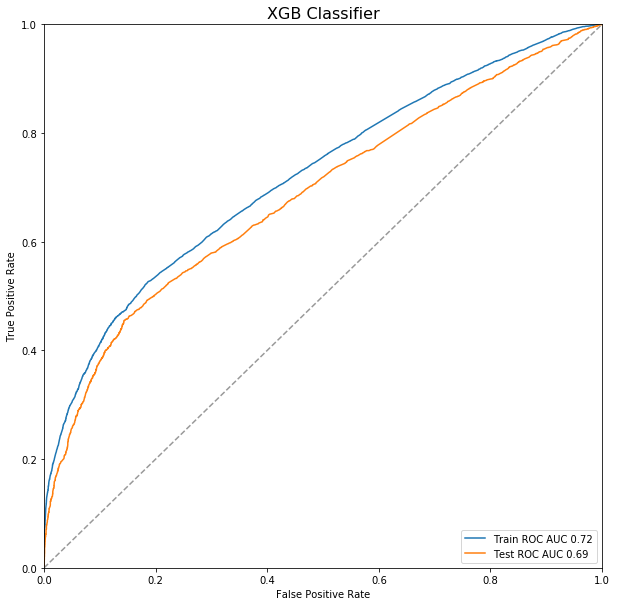

In [644]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

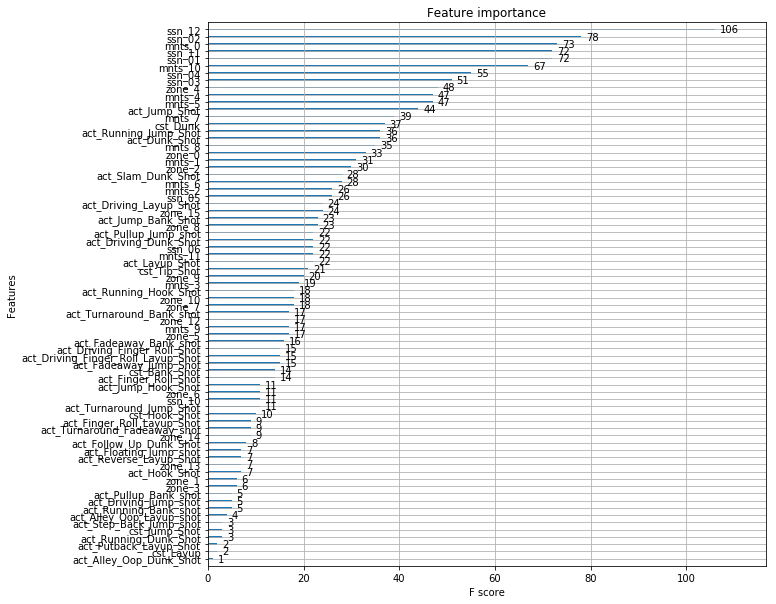

In [645]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')